In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


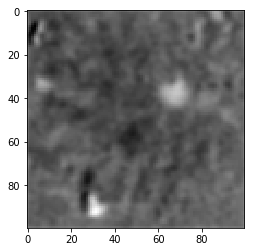

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = '13' #version no.
BATCH_SIZE = 8
lr01 = 0.00001
lr02 = 0.01
n_neurons = 40
MAX_EPOCHS = 2000
l1_coeff = 0.5
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


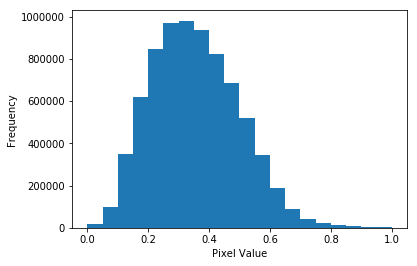

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[40 1 1 2]


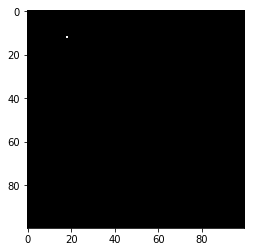

In [6]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same',
                        kernel_regularizer=l1(l1_coeff))(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same',
                    kernel_regularizer=l1(l1_coeff))(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same',
                      kernel_regularizer=l1(l1_coeff))(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same',
                      kernel_regularizer=l1(l1_coeff))(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same',
                     kernel_regularizer=l1(l1_coeff))(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same',
                       kernel_regularizer=l1(l1_coeff))(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return duplicate_imgs

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

In [8]:
def encoder02(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 256, kernel_size = 1, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same")(leaky01 )
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(leaky02 )
    return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder02(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_onehot = tf.keras.optimizers.Adam(lr02)
#loss function 
mse = tf.losses.MeanSquaredError()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
        one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
        #duplicate summed one_hot_images and compare with encoded output 
        #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
        duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        
#         #sanity check
#         black_images = tf.zeros([BATCH_SIZE, 100,100,1], dtype=tf.float32)
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)
        
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #loss between the encoded output and the one hot images 
        encoded_one_loss = mse(encoder_output, duplicated_one_hot)
#         encoded_one_loss = mse(encoder_output, black_images)
        #append loss 
        loss = [global_loss, encoded_one_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder + learnable_coords
    varis_encoded_one = l_coords.trainable_variables
    grad_partial = tape.gradient(encoded_one_loss, varis_encoded_one)
    opt_encoded_onehot.apply_gradients(zip(grad_partial, varis_encoded_one))
    
    grad = [grad_model, grad_partial]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

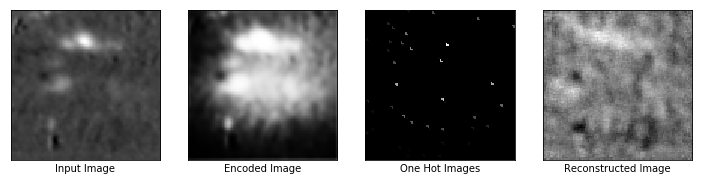

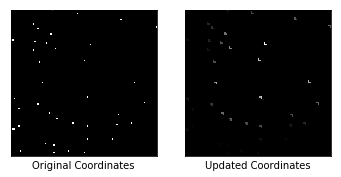

Epochs: 100, Reconstruction Loss: 0.003523411462083459
Similarity Loss: 0.4693438410758972
Max Similarity scores: 0.992053747177124
Updated Coordinates: [[[0.18461758 0.11916144]]]
Gradient global min:-0.0005332225700840354, max:0.0003392065118532628
Gradient partial min:-3.537721204338595e-05, max:3.411053694435395e-05



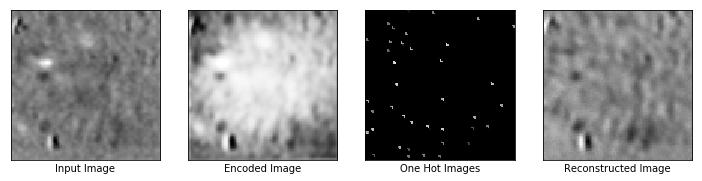

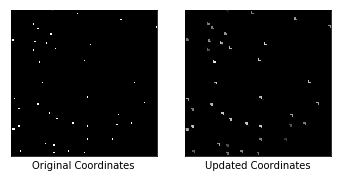

Epochs: 200, Reconstruction Loss: 0.0024438065011054277
Similarity Loss: 0.3752136826515198
Max Similarity scores: 0.9812275767326355
Updated Coordinates: [[[0.18462548 0.11915066]]]
Gradient global min:0.0008622559835202992, max:0.0008622559835202992
Gradient partial min:-4.6475826820824295e-05, max:3.6717523471452296e-05



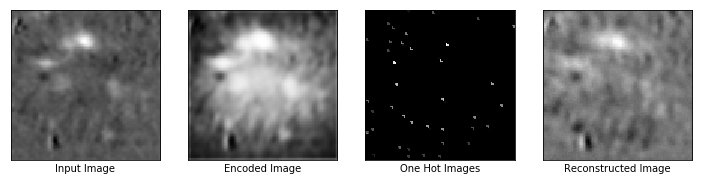

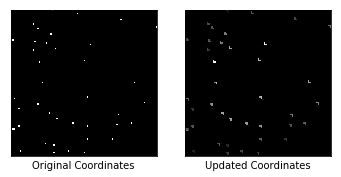

Epochs: 300, Reconstruction Loss: 0.0019117393530905247
Similarity Loss: 0.3505845367908478
Max Similarity scores: 0.9340367913246155
Updated Coordinates: [[[0.18461806 0.1191396 ]]]
Gradient global min:-2.442988807160873e-05, max:2.414432128716726e-05
Gradient partial min:-4.628219176083803e-05, max:3.808914698311128e-05



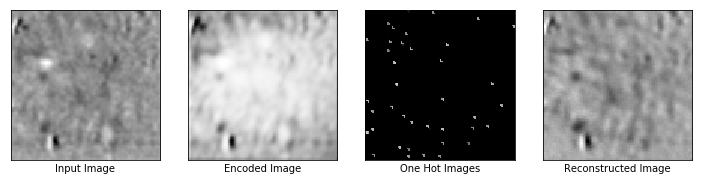

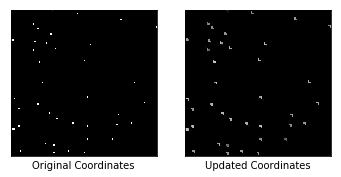

Epochs: 400, Reconstruction Loss: 0.0017138638067990541
Similarity Loss: 0.34732264280319214
Max Similarity scores: 0.9690778851509094
Updated Coordinates: [[[0.18461223 0.11913532]]]
Gradient global min:-0.0005996532272547483, max:0.0009470165823586285
Gradient partial min:-5.27130214322824e-05, max:4.1953768231906e-05



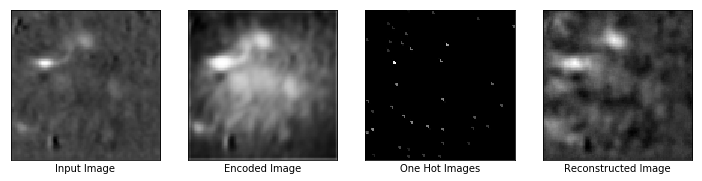

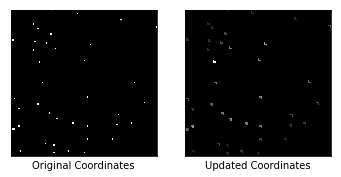

Epochs: 500, Reconstruction Loss: 0.0016219507670029998
Similarity Loss: 0.34713253378868103
Max Similarity scores: 0.963994562625885
Updated Coordinates: [[[0.18460846 0.11913349]]]
Gradient global min:-0.00018123092013411224, max:0.00023139725090004504
Gradient partial min:-5.203926775720902e-05, max:4.161140896030702e-05



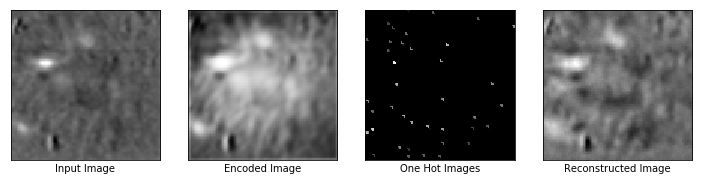

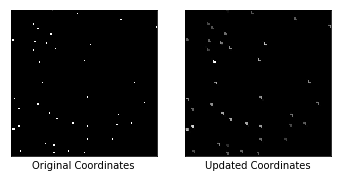

Epochs: 600, Reconstruction Loss: 0.0015662788646295667
Similarity Loss: 0.3460621237754822
Max Similarity scores: 0.9680851101875305
Updated Coordinates: [[[0.18460649 0.11913288]]]
Gradient global min:-3.668034332804382e-05, max:0.0005495482473634183
Gradient partial min:-5.1584433094831184e-05, max:4.13789639424067e-05



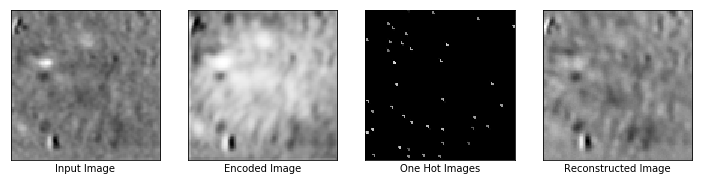

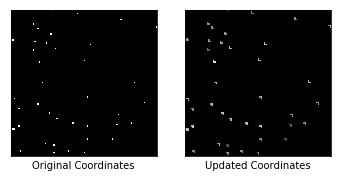

Epochs: 700, Reconstruction Loss: 0.0015271035954356194
Similarity Loss: 0.34513846039772034
Max Similarity scores: 0.962052583694458
Updated Coordinates: [[[0.18460472 0.11913247]]]
Gradient global min:0.0006392272189259529, max:0.0006392272189259529
Gradient partial min:-5.1650829846039414e-05, max:4.134697883273475e-05



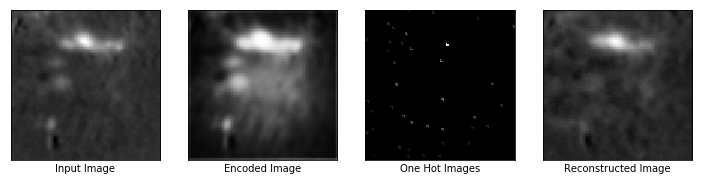

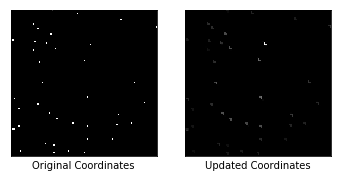

Epochs: 800, Reconstruction Loss: 0.0014900569804012775
Similarity Loss: 0.34576448798179626
Max Similarity scores: 0.9360339641571045
Updated Coordinates: [[[0.18460295 0.11913246]]]
Gradient global min:-0.0005068279569968581, max:0.00028594143805094063
Gradient partial min:-5.132791193318553e-05, max:4.090913716936484e-05



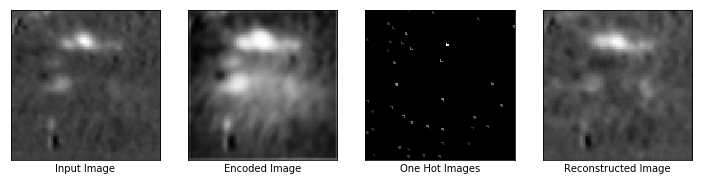

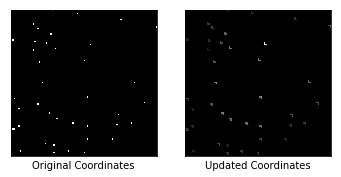

Epochs: 900, Reconstruction Loss: 0.0014514941722154617
Similarity Loss: 0.34771528840065
Max Similarity scores: 0.9182587265968323
Updated Coordinates: [[[0.18460138 0.11913259]]]
Gradient global min:-0.0007312787347473204, max:0.00041584932478144765
Gradient partial min:-5.147657429915853e-05, max:4.088446803507395e-05



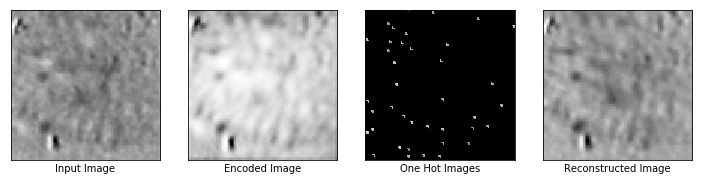

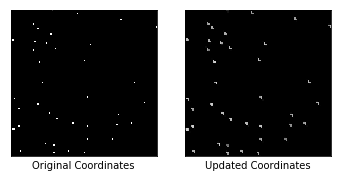

Epochs: 1000, Reconstruction Loss: 0.0014130636118352413
Similarity Loss: 0.34980010986328125
Max Similarity scores: 0.9345306754112244
Updated Coordinates: [[[0.18460013 0.119133  ]]]
Gradient global min:-0.0007340489537455142, max:0.0009049585787579417
Gradient partial min:-5.137088010087609e-05, max:4.0727438317844644e-05



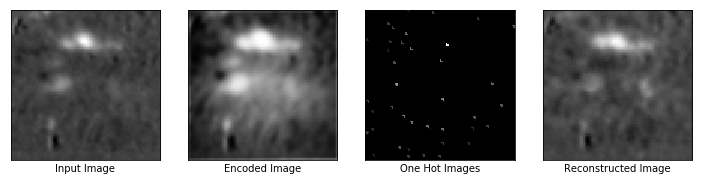

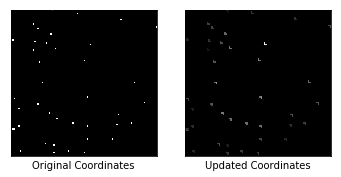

Epochs: 1100, Reconstruction Loss: 0.0013753551756963134
Similarity Loss: 0.35235777497291565
Max Similarity scores: 0.9161237478256226
Updated Coordinates: [[[0.18459877 0.119133  ]]]
Gradient global min:-0.0004492676816880703, max:0.0002697725431062281
Gradient partial min:-5.148511991137639e-05, max:4.073248419445008e-05



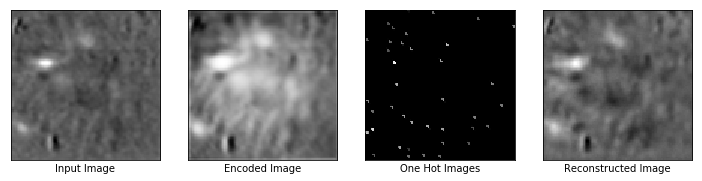

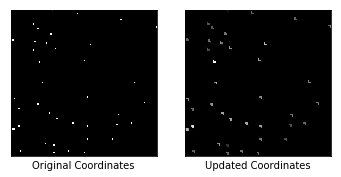

Epochs: 1200, Reconstruction Loss: 0.0013403755147010088
Similarity Loss: 0.35434210300445557
Max Similarity scores: 0.9661316275596619
Updated Coordinates: [[[0.1845974  0.11913291]]]
Gradient global min:-0.00011854084732476622, max:0.0004570577584672719
Gradient partial min:-5.134182356414385e-05, max:4.060833452967927e-05



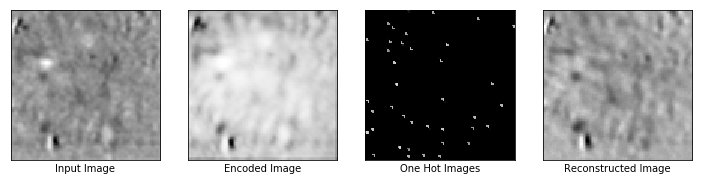

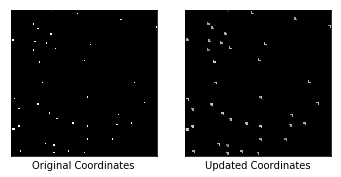

Epochs: 1300, Reconstruction Loss: 0.0013060936471447349
Similarity Loss: 0.35577255487442017
Max Similarity scores: 0.9684453010559082
Updated Coordinates: [[[0.18459617 0.11913302]]]
Gradient global min:-0.0007495380123145878, max:0.0009233884629793465
Gradient partial min:-5.139734275871888e-05, max:4.057527257828042e-05



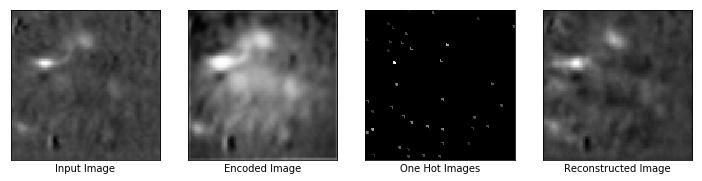

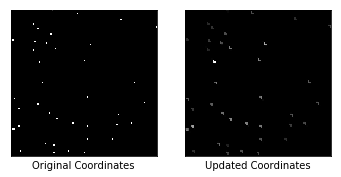

Epochs: 1400, Reconstruction Loss: 0.0012719391379505396
Similarity Loss: 0.35675448179244995
Max Similarity scores: 0.9585825204849243
Updated Coordinates: [[[0.1845945  0.11913299]]]
Gradient global min:-0.0001307408238062635, max:8.356803300557658e-05
Gradient partial min:-5.128622069605626e-05, max:4.0450988308293745e-05



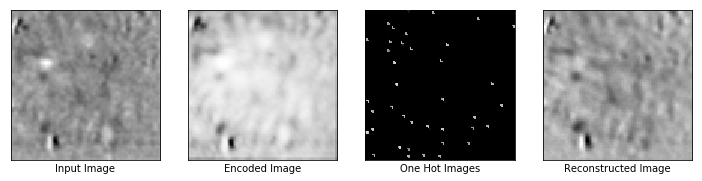

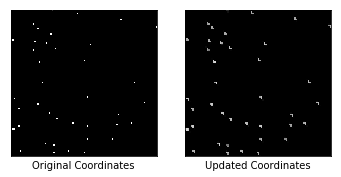

Epochs: 1500, Reconstruction Loss: 0.0012396143283694983
Similarity Loss: 0.35760772228240967
Max Similarity scores: 0.9692027568817139
Updated Coordinates: [[[0.18459329 0.11913271]]]
Gradient global min:-0.0007188800955191255, max:0.0009530276875011623
Gradient partial min:-5.105314266984351e-05, max:4.01781580876559e-05



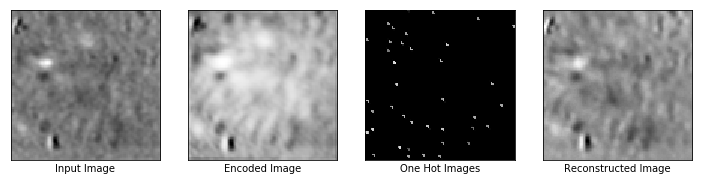

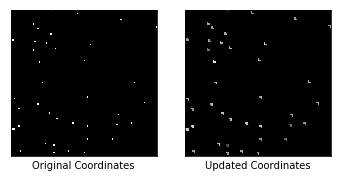

Epochs: 1600, Reconstruction Loss: 0.0012073565740138292
Similarity Loss: 0.35786402225494385
Max Similarity scores: 0.9642093181610107
Updated Coordinates: [[[0.18459174 0.11913213]]]
Gradient global min:-0.0003313820925541222, max:-0.0003313820925541222
Gradient partial min:-5.108365439809859e-05, max:4.020482083433308e-05



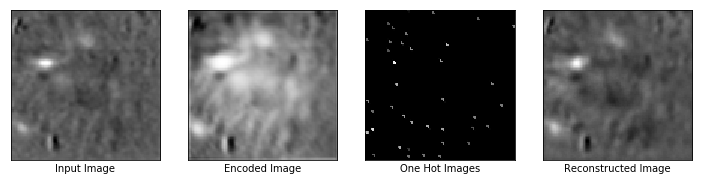

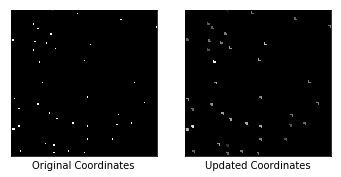

Epochs: 1700, Reconstruction Loss: 0.0011724651558324695
Similarity Loss: 0.3579927682876587
Max Similarity scores: 0.966289222240448
Updated Coordinates: [[[0.18459111 0.11913182]]]
Gradient global min:-0.0003367218014318496, max:0.0004311525553930551
Gradient partial min:-5.0969851145055145e-05, max:4.010917109553702e-05



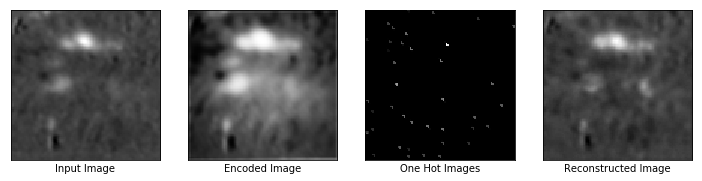

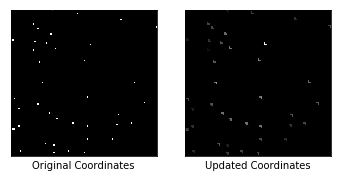

Epochs: 1800, Reconstruction Loss: 0.0011416717898100615
Similarity Loss: 0.35779690742492676
Max Similarity scores: 0.9077780246734619
Updated Coordinates: [[[0.18459022 0.11913154]]]
Gradient global min:-0.0004208726459182799, max:0.0005031247856095433
Gradient partial min:-5.098290421301499e-05, max:4.013014768133871e-05



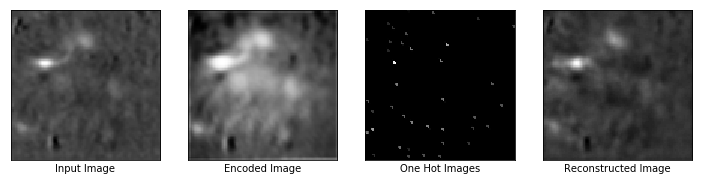

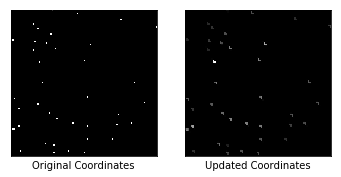

Epochs: 1900, Reconstruction Loss: 0.001114022801630199
Similarity Loss: 0.3576146364212036
Max Similarity scores: 0.9583713412284851
Updated Coordinates: [[[0.1845898  0.11913066]]]
Gradient global min:-0.00011206830095034093, max:0.00015100184828042984
Gradient partial min:-5.102269642520696e-05, max:4.013314901385456e-05



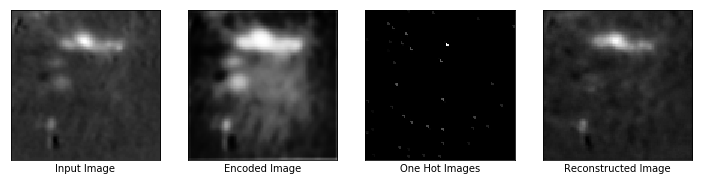

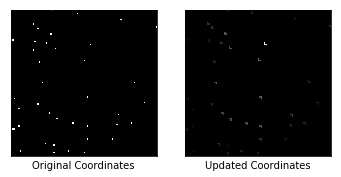

Epochs: 2000, Reconstruction Loss: 0.0010818697046488523
Similarity Loss: 0.3568723201751709
Max Similarity scores: 0.9256846308708191
Updated Coordinates: [[[0.18458934 0.11913041]]]
Gradient global min:-0.000452502747066319, max:0.00025691857445053756
Gradient partial min:-5.10418503836263e-05, max:4.01623074139934e-05


In [12]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, IMG_SIZE, BATCH_SIZE)
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Similarity Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient partial min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
    #append list for every 100 epochs 
#     if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

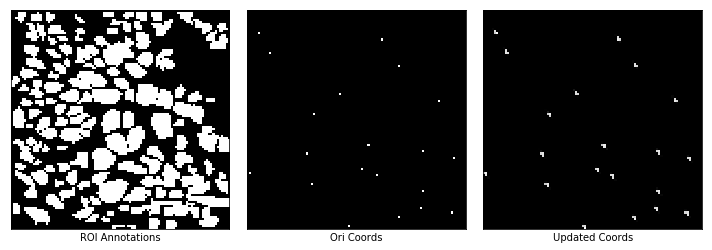

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.002
Counts:  60


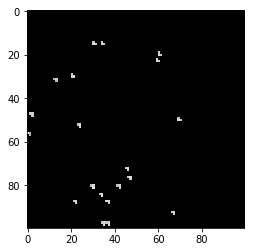

In [25]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

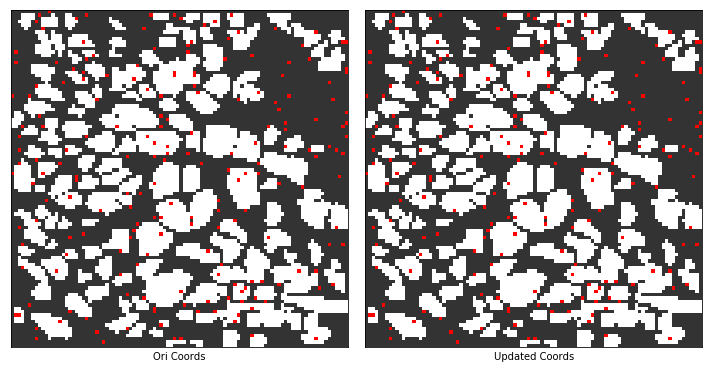

In [9]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [12]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0074
True Negatives:  0.0123
False Positive Ratio:  0.4112
False Negatives Ratio:  0.5691
F1 score:  0.03376682637462925


---

# Similarity Scores with Threshold

In [111]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.8)

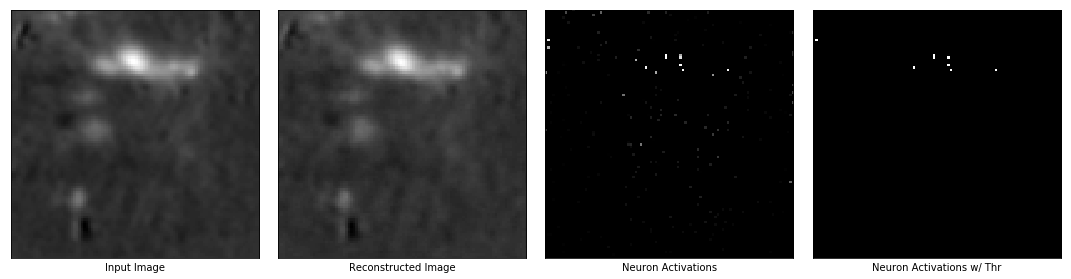

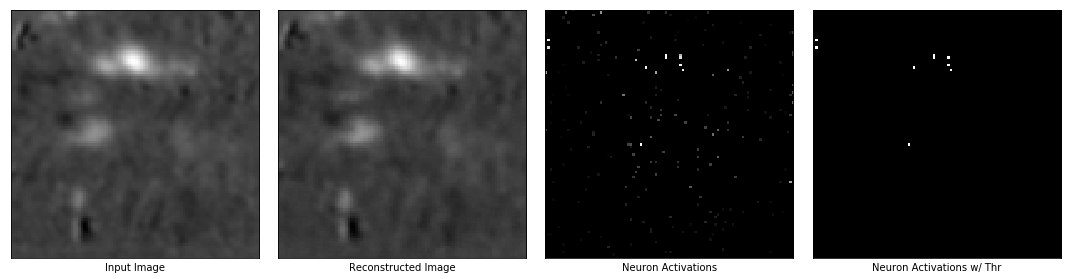

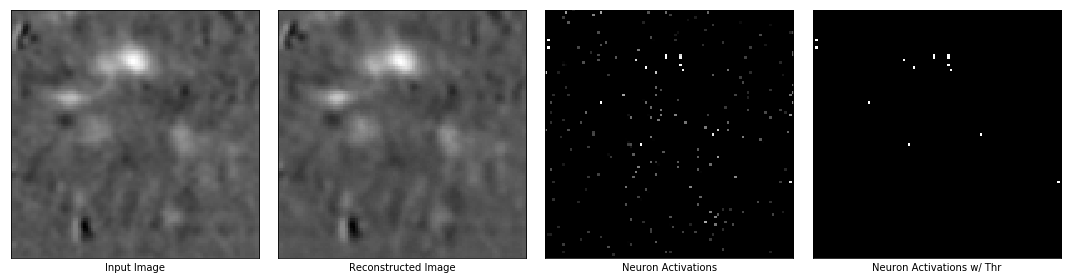

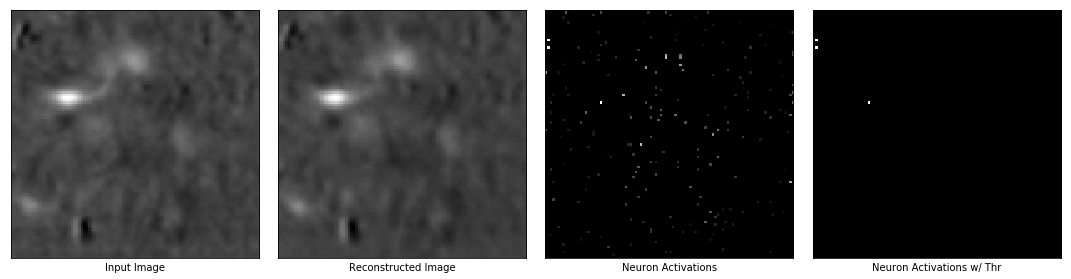

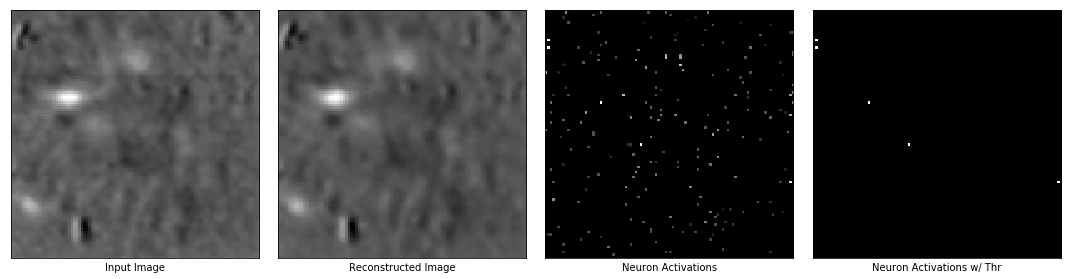

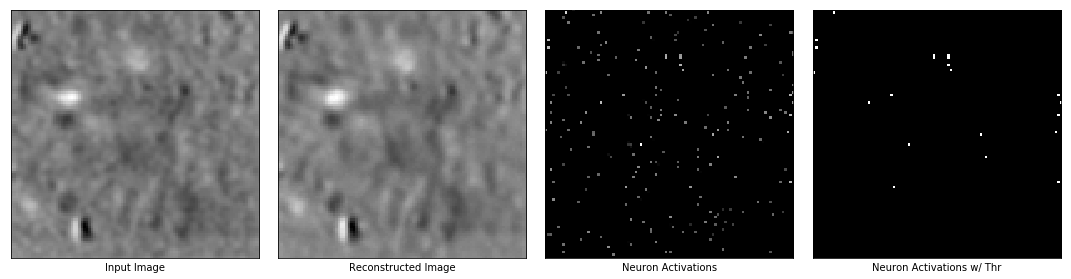

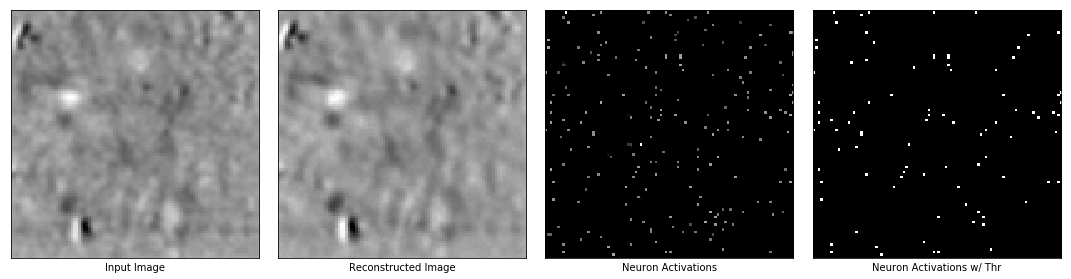

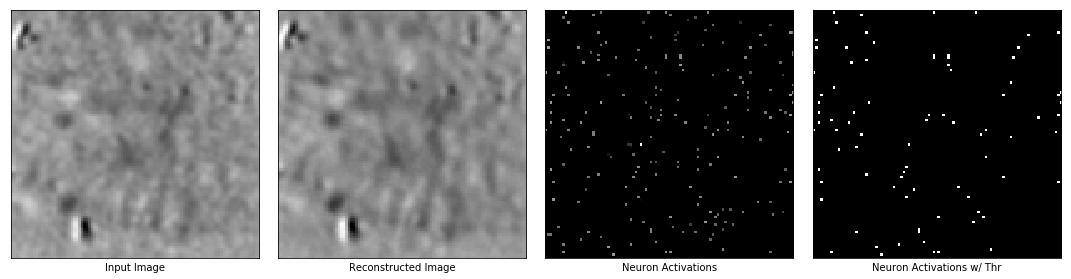

In [19]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

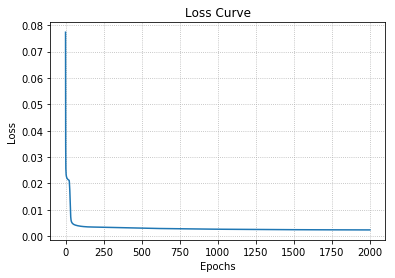

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [23]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_08.h5")
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_08.h5")

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [24]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_3
flatten_1
dense
reshape
up_sampling2d
coord_conv_14
activation
up_sampling2d_1
conv2d_22
activation_1
conv2d_23


In [25]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


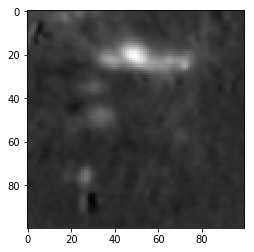

In [12]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


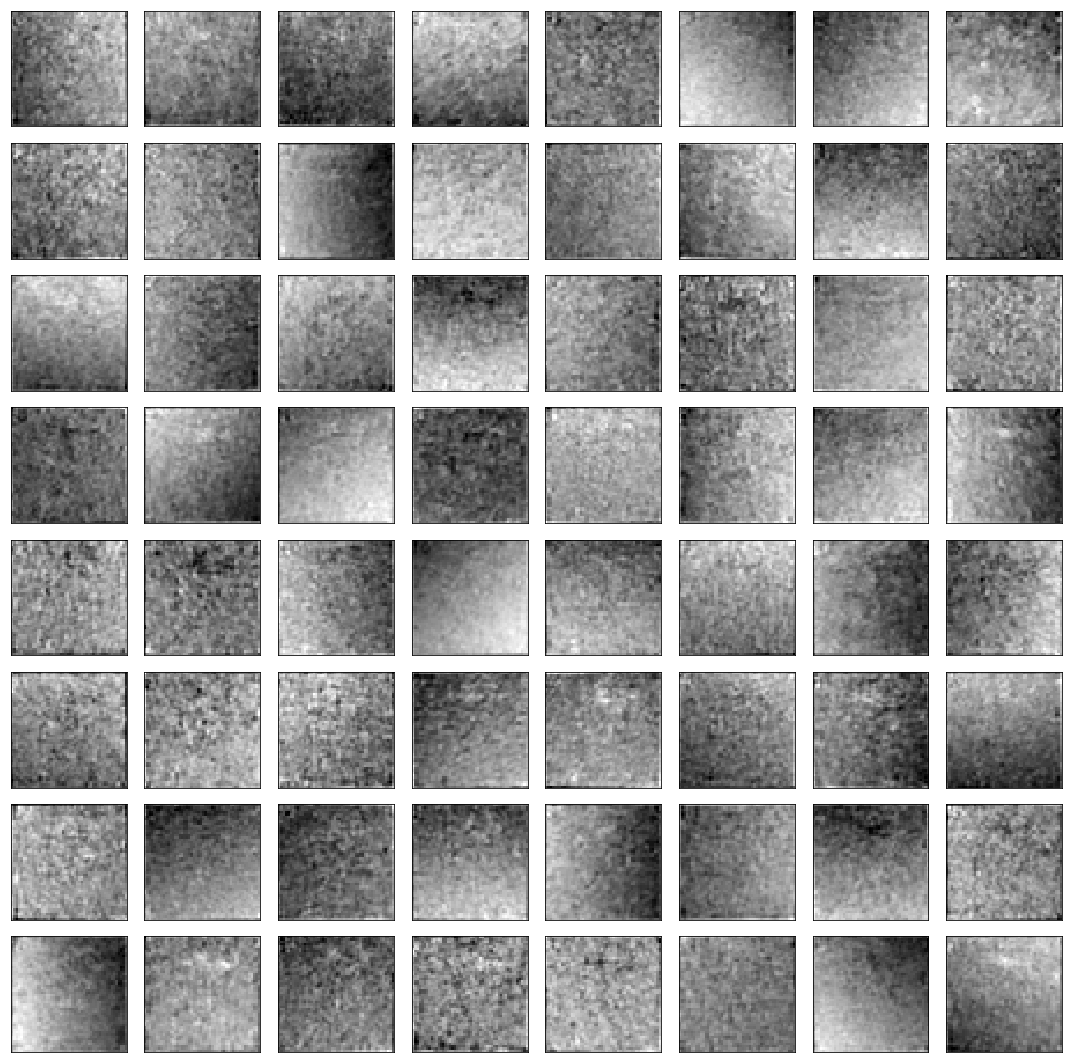

In [27]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_14', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


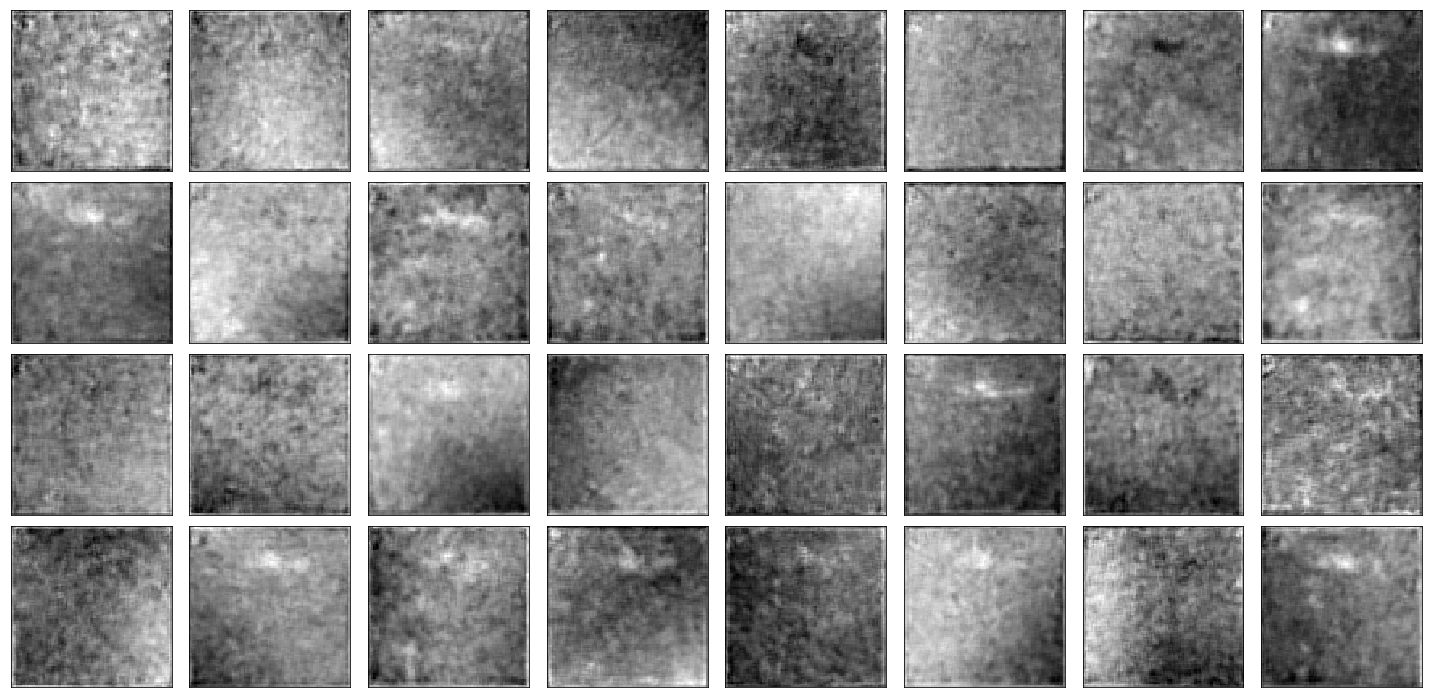

In [28]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_22', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

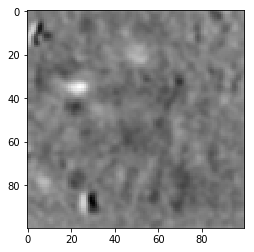

In [41]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [45]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


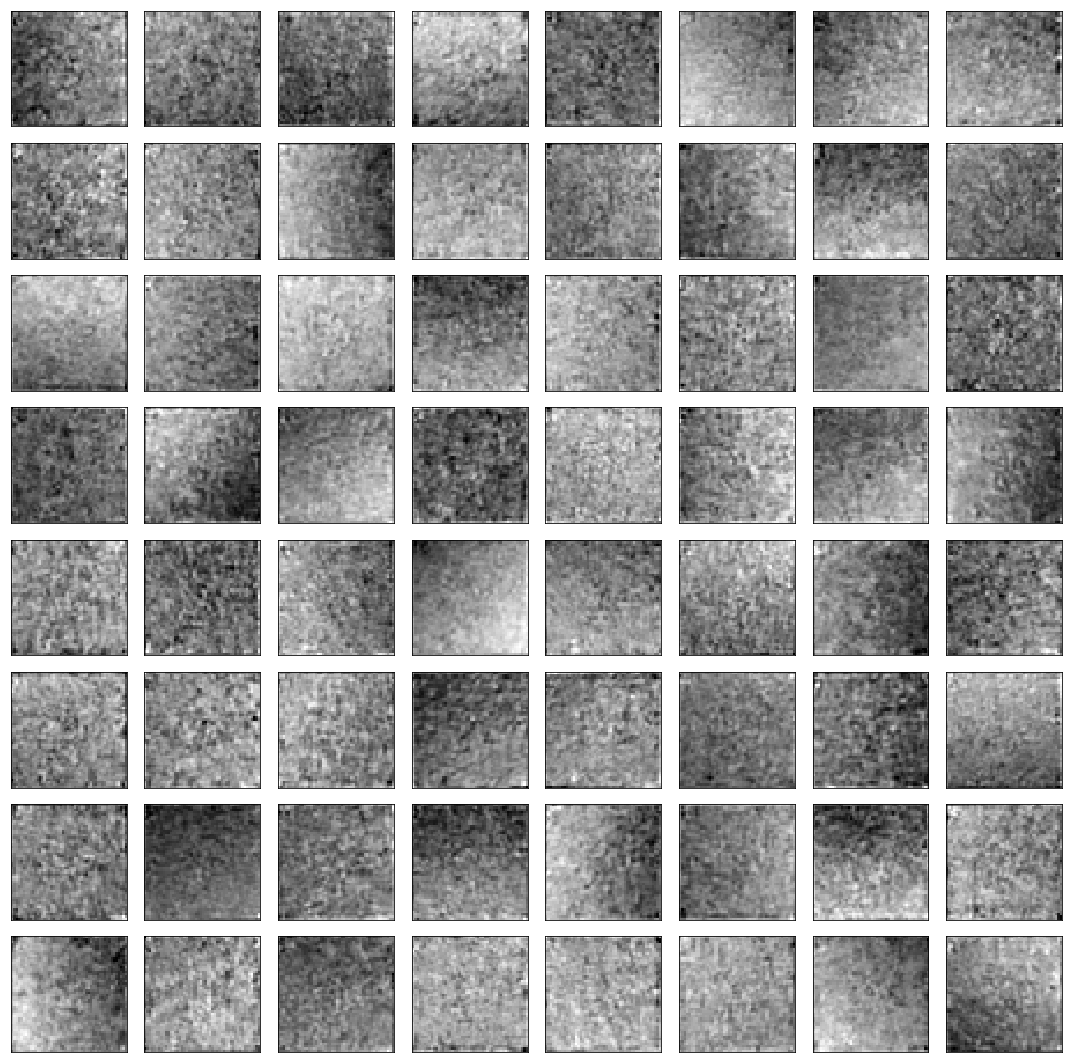

In [46]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_14', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


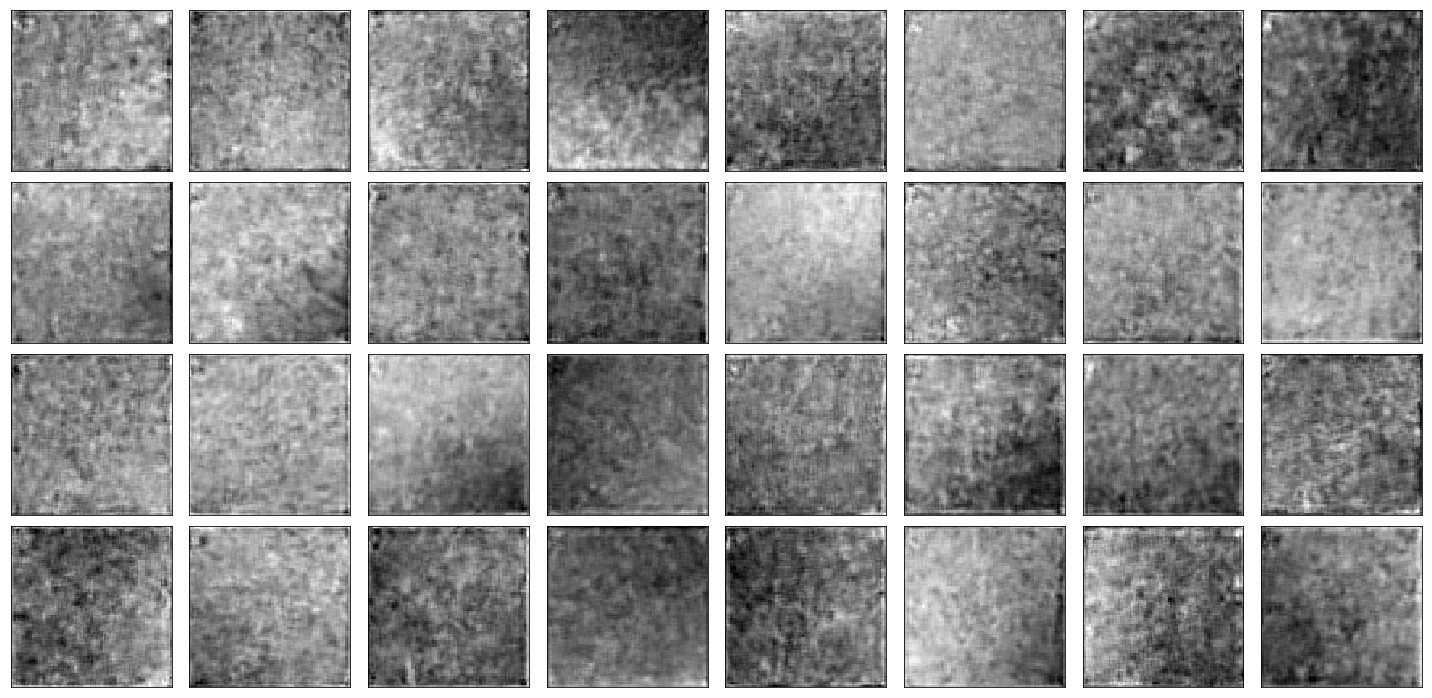

In [47]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_22', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [48]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [49]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [50]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

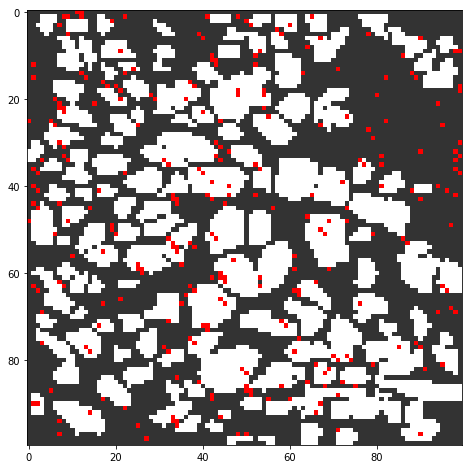

In [107]:
plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

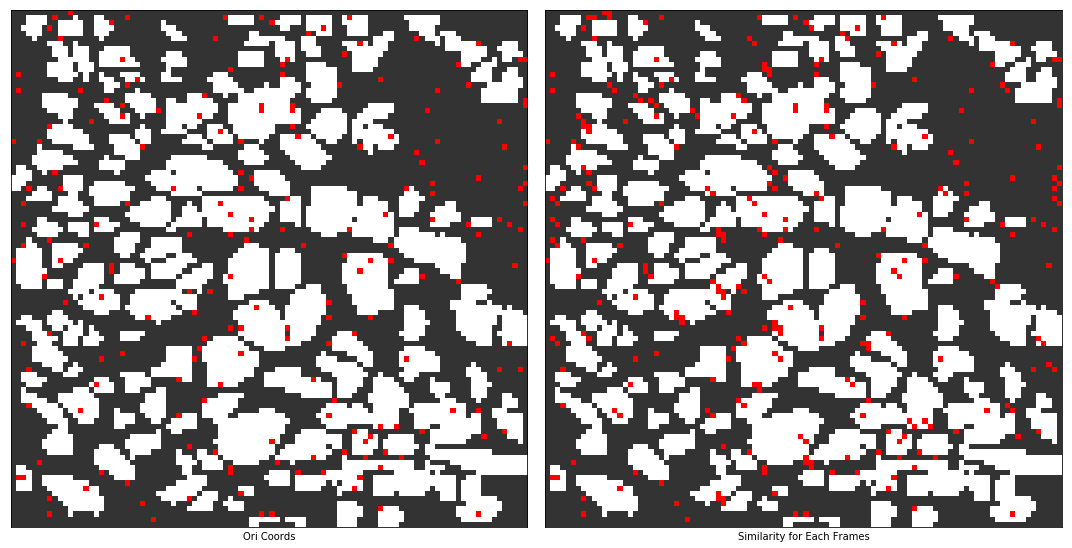

Counts:  274


In [108]:
captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)